In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Deep_Q_learning_network

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the Q-network (Deep Q-Learning Neural Network)
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

# Step 3: Define the Experience Replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

# Step 4: Define the DQN agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=1e-3, batch_size=32):
        self.action_dim = action_dim
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        # Initialize the Q-network and the target network
        self.q_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Copy parameters from Q-network

        # Set the optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Experience replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size=10000)

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(self.action_dim)
        else:
            # Exploitation: Choose the action with the highest Q-value
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.q_network(state_tensor).detach().numpy()
            return np.argmax(q_values)

    def update(self):
        if self.replay_buffer.size() < self.batch_size:
            return  # If the buffer doesn't have enough samples, we do nothing
        
        # Sample a batch of transitions from the replay buffer
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Compute Q-values for the current states
        q_values = self.q_network(states)
        q_values_selected = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute Q-values for the next states from the target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            next_q_values_max = next_q_values.max(1)[0]

        # Compute the target Q-values
        target_q_values = rewards + self.gamma * next_q_values_max * (1 - dones)

        # Compute the loss (Mean Squared Error)
        loss = torch.nn.functional.mse_loss(q_values_selected, target_q_values)

        # Backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon (exploration rate)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, n_episodes):
        for episode in range(n_episodes):
            state = np.random.choice([0, 1], size=n_skus)  # Random initial state (binary vector for SKU selection)
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                # Simulate the reward (revenue) based on the selected action
                reward = self.calculate_revenue(state)  # Reward is the normalized revenue
                next_state = np.random.choice([0, 1], size=n_skus)  # Next state after taking action (random for simplicity)
                done = True  # End the episode after one step for simplicity
                total_reward += reward

                # Store experience in the replay buffer
                self.replay_buffer.push(state, action, reward, next_state, done)

                # Update the Q-network using a batch of experiences
                self.update()

                state = next_state

            print(f"Episode {episode+1}/{n_episodes}, Total Reward: {total_reward}")

            # Update the target network every few episodes
            if episode % 10 == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())

    def calculate_revenue(self, state):
        # Calculate the revenue (normalized) based on the selected SKUs
        revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
        return revenue

# Step 5: Train the DQN agent
agent = DQNAgent(state_dim=n_skus, action_dim=n_skus)

# Train for 1000 episodes
agent.train(n_episodes=1000)


Episode 1/1000, Total Reward: 1.9050290097079885
Episode 2/1000, Total Reward: 1.7939530555075567
Episode 3/1000, Total Reward: 0.0
Episode 4/1000, Total Reward: 0.3009037716033134
Episode 5/1000, Total Reward: 1.9440406870963993
Episode 6/1000, Total Reward: 1.8598698009484638
Episode 7/1000, Total Reward: 0.38507465775124894
Episode 8/1000, Total Reward: 2.0099574325373064
Episode 9/1000, Total Reward: 0.23498702616240622
Episode 10/1000, Total Reward: 1.6239953310116946
Episode 11/1000, Total Reward: 0.3200453560847048
Episode 12/1000, Total Reward: 0.1699577244958621
Episode 13/1000, Total Reward: 0.1699577244958621
Episode 14/1000, Total Reward: 1.924899102615008
Episode 15/1000, Total Reward: 0.2358744699367693
Episode 16/1000, Total Reward: 2.0749867342038506
Episode 17/1000, Total Reward: 0.1500876315888427
Episode 18/1000, Total Reward: 0.385962101525612
Episode 19/1000, Total Reward: 1.9050290097079885
Episode 20/1000, Total Reward: 0.06591674544090718
Episode 21/1000, Total 

<ipython-input-2-20ff248de320>:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 45/1000, Total Reward: 0.3009037716033134
Episode 46/1000, Total Reward: 0.2151169332553868
Episode 47/1000, Total Reward: 0.06502930166654411
Episode 48/1000, Total Reward: 1.8598698009484638
Episode 49/1000, Total Reward: 2.0749867342038506
Episode 50/1000, Total Reward: 0.45099140319215614
Episode 51/1000, Total Reward: 1.8598698009484638
Episode 52/1000, Total Reward: 1.9050290097079885
Episode 53/1000, Total Reward: 1.7939530555075567
Episode 54/1000, Total Reward: 0.06502930166654411
Episode 55/1000, Total Reward: 1.7939530555075567
Episode 56/1000, Total Reward: 1.7939530555075567
Episode 57/1000, Total Reward: 1.6890246326782388
Episode 58/1000, Total Reward: 0.1699577244958621
Episode 59/1000, Total Reward: 0.1699577244958621
Episode 60/1000, Total Reward: 1.7549413781191459
Episode 61/1000, Total Reward: 0.06502930166654411
Episode 62/1000, Total Reward: 0.1500876315888427
Episode 63/1000, Total Reward: 0.385962101525612
Episode 64/1000, Total Reward: 0.21600437702974

## Multi-Armed Bandit (MAB) problem using the ε-greedy strategy in reinforcement learning

In [3]:
import numpy as np
import pandas as pd
import random

# 1. Define a Dummy Dataset
np.random.seed(42)

n_products = 5  # Number of products
n_clusters = 2  # Number of clusters (just an example)

# Create a dummy dataset
product_data = pd.DataFrame({
    'utility': np.random.rand(n_products),  # Random utilities between 0 and 1
    'price': np.random.rand(n_products) * 10,  # Random prices between 0 and 10
    'share': np.random.rand(n_products)  # Random share percentages between 0 and 1
})

# 2. Multi-Armed Bandit Algorithm (ε-greedy)
class EGreedyBandit:
    def __init__(self, n_actions, epsilon=0.1):
        self.n_actions = n_actions  # Number of products (arms)
        self.epsilon = epsilon  # Exploration rate
        self.q_values = np.zeros(n_actions)  # Estimated Q-values for each product (initialized to 0)
        self.action_counts = np.zeros(n_actions)  # Count of how many times each product was selected

    def select_action(self):
        if np.random.rand() < self.epsilon:
            # Exploration: Choose a random product
            return np.random.randint(self.n_actions)
        else:
            # Exploitation: Choose the product with the highest Q-value (estimated reward)
            return np.argmax(self.q_values)

    def update_q_values(self, action, reward):
        # Update the estimated Q-value for the selected product using the average reward formula
        self.action_counts[action] += 1
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

# 3. Training Loop
n_episodes = 1000  # Number of episodes
epsilon = 0.1  # Exploration rate (chance to randomly explore a product)
agent = EGreedyBandit(n_actions=n_products, epsilon=epsilon)

# Training the agent
for e in range(n_episodes):
    # Choose an action (product to select) based on the epsilon-greedy strategy
    action = agent.select_action()

    # Simulate the reward for the chosen action (reward = utility * share)
    reward = product_data.iloc[action]['utility'] * product_data.iloc[action]['share']

    # Update the estimated Q-value (expected reward) for the selected product
    agent.update_q_values(action, reward)

    # Print progress every 100 episodes
    if e % 100 == 0:
        print(f"Episode {e}/{n_episodes}, Epsilon: {agent.epsilon}, Estimated Q-values: {agent.q_values}")

# 4. Final Evaluation
final_action = np.argmax(agent.q_values)  # Choose the product with the highest estimated Q-value
print(f"Final action (selected product): {final_action}")


Episode 0/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.         0.         0.         0.        ]
Episode 100/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 200/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 300/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 400/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 500/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 600/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 700/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 800/1000, Epsilon: 0.1, Estimated Q-values: [0.00770972 0.92210717 0.60934297 0.12711861 0.02836808]
Episode 900/1000, Eps

## vanilla Q learning 

In [4]:
import numpy as np
import random
import pandas as pd

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the Q-learning agent
class QLearningAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.1, batch_size=32):
        self.action_dim = action_dim
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr  # Learning rate

        # Initialize the Q-table
        self.q_table = np.zeros((2**state_dim, action_dim))  # State space is represented as binary vectors of length `state_dim`

    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(self.action_dim)
        else:
            # Exploitation: Choose the action with the highest Q-value
            state_idx = self.state_to_idx(state)
            return np.argmax(self.q_table[state_idx])

    def state_to_idx(self, state):
        """Convert binary state representation to index for the Q-table"""
        return int("".join(map(str, state)), 2)

    def update(self, state, action, reward, next_state, done):
        # Q-value update using the Bellman equation
        state_idx = self.state_to_idx(state)
        next_state_idx = self.state_to_idx(next_state)

        # Get the current Q-value for the chosen action
        q_value = self.q_table[state_idx, action]

        # Get the maximum Q-value for the next state (for exploitation)
        next_q_value = np.max(self.q_table[next_state_idx]) if not done else 0

        # Q-learning update rule
        new_q_value = q_value + self.lr * (reward + self.gamma * next_q_value - q_value)

        # Update the Q-table with the new Q-value
        self.q_table[state_idx, action] = new_q_value

        # Decay epsilon (for exploration)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, n_episodes):
        for episode in range(n_episodes):
            state = np.random.choice([0, 1], size=n_skus)  # Random initial state (binary vector for SKU selection)
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                # Simulate the reward (revenue) based on the selected action
                reward = self.calculate_revenue(state)  # Reward is the normalized revenue
                next_state = np.random.choice([0, 1], size=n_skus)  # Next state after taking action (random for simplicity)
                done = True  # End the episode after one step for simplicity
                total_reward += reward

                # Update the Q-table based on the chosen action and the reward
                self.update(state, action, reward, next_state, done)

                state = next_state

            print(f"Episode {episode+1}/{n_episodes}, Total Reward: {total_reward}")

    def calculate_revenue(self, state):
        # Calculate the revenue (normalized) based on the selected SKUs
        revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
        return revenue

# Step 3: Train the Q-learning agent
agent = QLearningAgent(state_dim=n_skus, action_dim=n_skus)

# Train for 1000 episodes
agent.train(n_episodes=1000)


Episode 1/1000, Total Reward: 1.9050290097079885
Episode 2/1000, Total Reward: 1.7939530555075567
Episode 3/1000, Total Reward: 0.0
Episode 4/1000, Total Reward: 0.3009037716033134
Episode 5/1000, Total Reward: 1.9440406870963993
Episode 6/1000, Total Reward: 1.8598698009484638
Episode 7/1000, Total Reward: 0.38507465775124894
Episode 8/1000, Total Reward: 2.0099574325373064
Episode 9/1000, Total Reward: 0.23498702616240622
Episode 10/1000, Total Reward: 1.6239953310116946
Episode 11/1000, Total Reward: 0.3200453560847048
Episode 12/1000, Total Reward: 0.1699577244958621
Episode 13/1000, Total Reward: 0.1699577244958621
Episode 14/1000, Total Reward: 1.924899102615008
Episode 15/1000, Total Reward: 0.2358744699367693
Episode 16/1000, Total Reward: 2.0749867342038506
Episode 17/1000, Total Reward: 0.1500876315888427
Episode 18/1000, Total Reward: 0.385962101525612
Episode 19/1000, Total Reward: 1.9050290097079885
Episode 20/1000, Total Reward: 0.06591674544090718
Episode 21/1000, Total 

## SARSA- on policy reinforcement learning

In [5]:
import numpy as np
import random
import pandas as pd

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the SARSA agent
class SARSAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.1, batch_size=32):
        self.action_dim = action_dim
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr  # Learning rate

        # Initialize the Q-table
        self.q_table = np.zeros((2**state_dim, action_dim))  # State space is represented as binary vectors of length `state_dim`

    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(self.action_dim)
        else:
            # Exploitation: Choose the action with the highest Q-value
            state_idx = self.state_to_idx(state)
            return np.argmax(self.q_table[state_idx])

    def state_to_idx(self, state):
        """Convert binary state representation to index for the Q-table"""
        return int("".join(map(str, state)), 2)

    def update(self, state, action, reward, next_state, next_action, done):
        # SARSA update rule using Q(s, a) ← Q(s, a) + α * [r + γ * Q(s', a') - Q(s, a)]
        state_idx = self.state_to_idx(state)
        next_state_idx = self.state_to_idx(next_state)

        # Get the current Q-value for the chosen action
        q_value = self.q_table[state_idx, action]

        # Get the Q-value for the next state and next action (for SARSA)
        next_q_value = self.q_table[next_state_idx, next_action] if not done else 0

        # SARSA update rule
        new_q_value = q_value + self.lr * (reward + self.gamma * next_q_value - q_value)

        # Update the Q-table with the new Q-value
        self.q_table[state_idx, action] = new_q_value

        # Decay epsilon (for exploration)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, n_episodes):
        for episode in range(n_episodes):
            state = np.random.choice([0, 1], size=n_skus)  # Random initial state (binary vector for SKU selection)
            done = False
            total_reward = 0

            # Select the first action for the episode
            action = self.select_action(state)

            while not done:
                # Simulate the reward (revenue) based on the selected action
                reward = self.calculate_revenue(state)  # Reward is the normalized revenue
                next_state = np.random.choice([0, 1], size=n_skus)  # Next state after taking action (random for simplicity)
                
                # Select the next action using the policy (ε-greedy)
                next_action = self.select_action(next_state)
                
                done = True  # End the episode after one step for simplicity
                total_reward += reward

                # Update the Q-table based on the chosen action and the reward using SARSA
                self.update(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action  # Update the action to the next action

            print(f"Episode {episode+1}/{n_episodes}, Total Reward: {total_reward}")

    def calculate_revenue(self, state):
        # Calculate the revenue (normalized) based on the selected SKUs
        revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
        return revenue

# Step 3: Train the SARSA agent
agent = SARSAgent(state_dim=n_skus, action_dim=n_skus)

# Train for 1000 episodes
agent.train(n_episodes=1000)


Episode 1/1000, Total Reward: 1.9050290097079885
Episode 2/1000, Total Reward: 1.9050290097079885
Episode 3/1000, Total Reward: 0.1699577244958621
Episode 4/1000, Total Reward: 0.3009037716033134
Episode 5/1000, Total Reward: 0.385962101525612
Episode 6/1000, Total Reward: 0.38507465775124894
Episode 7/1000, Total Reward: 0.0
Episode 8/1000, Total Reward: 0.1500876315888427
Episode 9/1000, Total Reward: 0.13094604710745128
Episode 10/1000, Total Reward: 0.06502930166654411
Episode 11/1000, Total Reward: 0.3200453560847048
Episode 12/1000, Total Reward: 0.13094604710745128
Episode 13/1000, Total Reward: 2.0749867342038506
Episode 14/1000, Total Reward: 1.7740829626005372
Episode 15/1000, Total Reward: 1.9050290097079885
Episode 16/1000, Total Reward: 0.06502930166654411
Episode 17/1000, Total Reward: 2.0099574325373064
Episode 18/1000, Total Reward: 0.38507465775124894
Episode 19/1000, Total Reward: 0.2151169332553868
Episode 20/1000, Total Reward: 1.6890246326782388
Episode 21/1000, To

Episode 1/1000, Total Reward: 1.9050290097079885
Episode 2/1000, Total Reward: 1.9050290097079885
Episode 3/1000, Total Reward: 0.1699577244958621
Episode 4/1000, Total Reward: 0.3009037716033134
Episode 5/1000, Total Reward: 0.385962101525612
Episode 6/1000, Total Reward: 0.38507465775124894
Episode 7/1000, Total Reward: 0.0
Episode 8/1000, Total Reward: 0.1500876315888427
Episode 9/1000, Total Reward: 0.13094604710745128
Episode 10/1000, Total Reward: 0.06502930166654411
Episode 11/1000, Total Reward: 0.3200453560847048
Episode 12/1000, Total Reward: 0.13094604710745128
Episode 13/1000, Total Reward: 2.0749867342038506
Episode 14/1000, Total Reward: 1.7740829626005372
Episode 15/1000, Total Reward: 1.9050290097079885
Episode 16/1000, Total Reward: 0.06502930166654411
Episode 17/1000, Total Reward: 2.0099574325373064
Episode 18/1000, Total Reward: 0.38507465775124894
Episode 19/1000, Total Reward: 0.2151169332553868
Episode 20/1000, Total Reward: 1.6890246326782388
Episode 21/1000, To

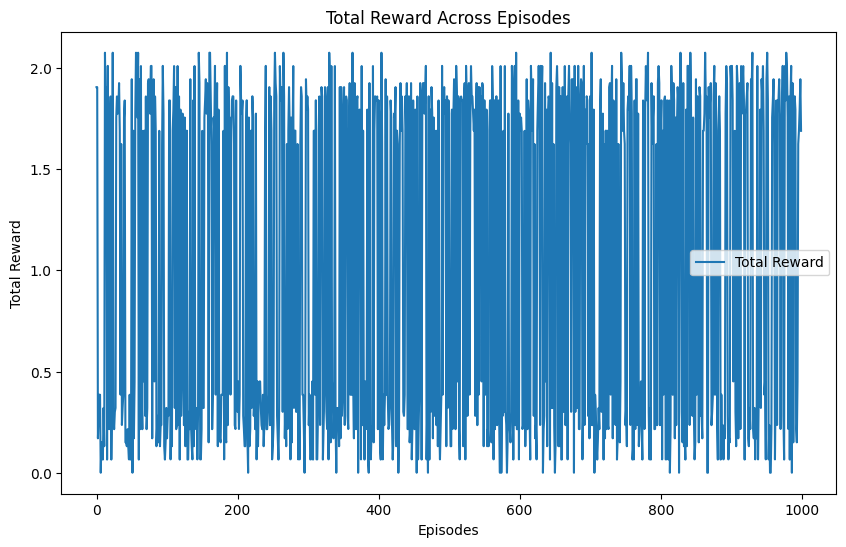

In [6]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the SARSA agent
class SARSAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.1, batch_size=32):
        self.action_dim = action_dim
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr  # Learning rate

        # Initialize the Q-table
        self.q_table = np.zeros((2**state_dim, action_dim))  # State space is represented as binary vectors of length `state_dim`
        self.reward_history = []  # List to store reward history

        # Track the best reward
        self.best_reward = -float('inf')
        self.best_episode = -1

    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(self.action_dim)
        else:
            # Exploitation: Choose the action with the highest Q-value
            state_idx = self.state_to_idx(state)
            return np.argmax(self.q_table[state_idx])

    def state_to_idx(self, state):
        """Convert binary state representation to index for the Q-table"""
        return int("".join(map(str, state)), 2)

    def update(self, state, action, reward, next_state, next_action, done):
        # SARSA update rule using Q(s, a) ← Q(s, a) + α * [r + γ * Q(s', a') - Q(s, a)]
        state_idx = self.state_to_idx(state)
        next_state_idx = self.state_to_idx(next_state)

        # Get the current Q-value for the chosen action
        q_value = self.q_table[state_idx, action]

        # Get the Q-value for the next state and next action (for SARSA)
        next_q_value = self.q_table[next_state_idx, next_action] if not done else 0

        # SARSA update rule
        new_q_value = q_value + self.lr * (reward + self.gamma * next_q_value - q_value)

        # Update the Q-table with the new Q-value
        self.q_table[state_idx, action] = new_q_value

        # Decay epsilon (for exploration)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, n_episodes):
        for episode in range(n_episodes):
            state = np.random.choice([0, 1], size=n_skus)  # Random initial state (binary vector for SKU selection)
            done = False
            total_reward = 0

            # Select the first action for the episode
            action = self.select_action(state)

            while not done:
                # Simulate the reward (revenue) based on the selected action
                reward = self.calculate_revenue(state)  # Reward is the normalized revenue
                next_state = np.random.choice([0, 1], size=n_skus)  # Next state after taking action (random for simplicity)
                
                # Select the next action using the policy (ε-greedy)
                next_action = self.select_action(next_state)
                
                done = True  # End the episode after one step for simplicity
                total_reward += reward

                # Update the Q-table based on the chosen action and the reward using SARSA
                self.update(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action  # Update the action to the next action

            # Print the reward for the current episode
            print(f"Episode {episode+1}/{n_episodes}, Total Reward: {total_reward}")

            # Store the total reward for plotting
            self.reward_history.append(total_reward)

            # Track the best reward and episode
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.best_episode = episode + 1  # Episode number starts from 1

        # Print the best reward and its corresponding episode after training ends
        print(f"\nBest Reward: {self.best_reward}, Achieved at Episode: {self.best_episode}")
        
        # Plotting the reward history across episodes
        self.plot_rewards()

    def calculate_revenue(self, state):
        # Calculate the revenue (normalized) based on the selected SKUs
        revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
        return revenue

    def plot_rewards(self):
        # Plot reward across all episodes
        plt.figure(figsize=(10, 6))
        plt.plot(self.reward_history, label="Total Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Total Reward Across Episodes")
        plt.legend()
        plt.show()

# Step 3: Train the SARSA agent
agent = SARSAgent(state_dim=n_skus, action_dim=n_skus)

# Train for 1000 episodes
agent.train(n_episodes=1000)


## PPO reinforcement learning

Episode 1/1000, Product Combination: [1 0 1 0 0], Total Reward: 1.9050290097079885
Episode 2/1000, Product Combination: [1 0 1 1 0], Total Reward: 1.9050290097079885
Episode 3/1000, Product Combination: [1 1 1 0 1], Total Reward: 0.1699577244958621
Episode 4/1000, Product Combination: [1 0 1 1 1], Total Reward: 0.3009037716033134
Episode 5/1000, Product Combination: [1 1 1 1 0], Total Reward: 0.385962101525612
Episode 6/1000, Product Combination: [1 1 0 1 1], Total Reward: 0.38507465775124894
Episode 7/1000, Product Combination: [1 0 1 1 1], Total Reward: 0.0
Episode 8/1000, Product Combination: [0 1 0 1 0], Total Reward: 0.1500876315888427
Episode 9/1000, Product Combination: [0 1 1 1 0], Total Reward: 0.13094604710745128
Episode 10/1000, Product Combination: [0 0 0 1 1], Total Reward: 0.06502930166654411
Episode 11/1000, Product Combination: [1 0 0 0 0], Total Reward: 0.3200453560847048
Episode 12/1000, Product Combination: [1 1 0 1 0], Total Reward: 0.13094604710745128
Episode 13/10

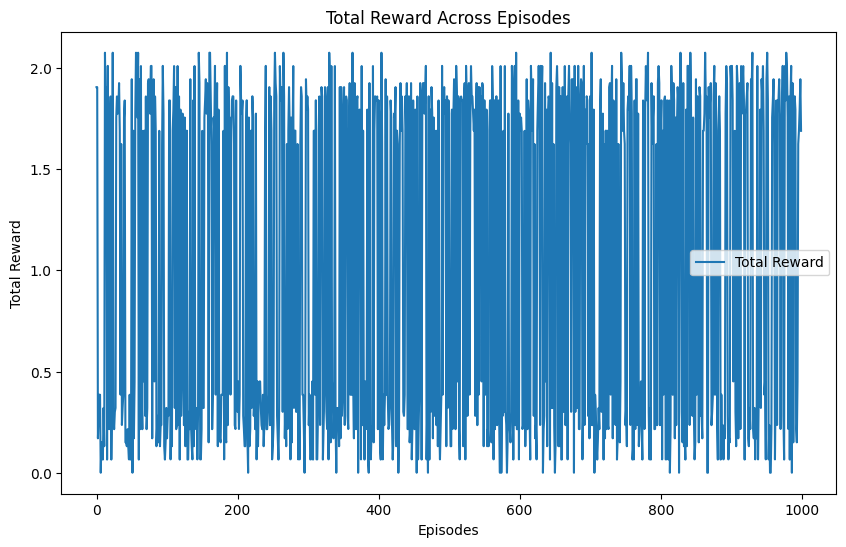

In [7]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the SARSA agent
class SARSAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.1, batch_size=32):
        self.action_dim = action_dim
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr  # Learning rate

        # Initialize the Q-table
        self.q_table = np.zeros((2**state_dim, action_dim))  # State space is represented as binary vectors of length `state_dim`
        self.reward_history = []  # List to store reward history

        # Track the best reward and best product combination
        self.best_reward = -float('inf')
        self.best_episode = -1
        self.best_combination = None

    def select_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return np.random.randint(self.action_dim)
        else:
            # Exploitation: Choose the action with the highest Q-value
            state_idx = self.state_to_idx(state)
            return np.argmax(self.q_table[state_idx])

    def state_to_idx(self, state):
        """Convert binary state representation to index for the Q-table"""
        return int("".join(map(str, state)), 2)

    def update(self, state, action, reward, next_state, next_action, done):
        # SARSA update rule using Q(s, a) ← Q(s, a) + α * [r + γ * Q(s', a') - Q(s, a)]
        state_idx = self.state_to_idx(state)
        next_state_idx = self.state_to_idx(next_state)

        # Get the current Q-value for the chosen action
        q_value = self.q_table[state_idx, action]

        # Get the Q-value for the next state and next action (for SARSA)
        next_q_value = self.q_table[next_state_idx, next_action] if not done else 0

        # SARSA update rule
        new_q_value = q_value + self.lr * (reward + self.gamma * next_q_value - q_value)

        # Update the Q-table with the new Q-value
        self.q_table[state_idx, action] = new_q_value

        # Decay epsilon (for exploration)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, n_episodes):
        for episode in range(n_episodes):
            state = np.random.choice([0, 1], size=n_skus)  # Random initial state (binary vector for SKU selection)
            done = False
            total_reward = 0

            # Select the first action for the episode
            action = self.select_action(state)

            while not done:
                # Simulate the reward (revenue) based on the selected action
                reward = self.calculate_revenue(state)  # Reward is the normalized revenue
                next_state = np.random.choice([0, 1], size=n_skus)  # Next state after taking action (random for simplicity)
                
                # Select the next action using the policy (ε-greedy)
                next_action = self.select_action(next_state)
                
                done = True  # End the episode after one step for simplicity
                total_reward += reward

                # Update the Q-table based on the chosen action and the reward using SARSA
                self.update(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action  # Update the action to the next action

            # Print the reward and product combination for the current episode
            print(f"Episode {episode+1}/{n_episodes}, Product Combination: {state}, Total Reward: {total_reward}")

            # Store the total reward for plotting
            self.reward_history.append(total_reward)

            # Track the best reward and product combination
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.best_episode = episode + 1  # Episode number starts from 1
                self.best_combination = state  # Save the product combination when the best reward is found

        # Print the best reward and the corresponding product combination after training ends
        print(f"\nBest Reward: {self.best_reward}, Achieved at Episode: {self.best_episode}, Best Product Combination: {self.best_combination}")
        
        # Plotting the reward history across episodes
        self.plot_rewards()

    def calculate_revenue(self, state):
        # Calculate the revenue (normalized) based on the selected SKUs
        revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
        return revenue

    def plot_rewards(self):
        # Plot reward across all episodes
        plt.figure(figsize=(10, 6))
        plt.plot(self.reward_history, label="Total Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Total Reward Across Episodes")
        plt.legend()
        plt.show()

# Step 3: Train the SARSA agent
agent = SARSAgent(state_dim=n_skus, action_dim=n_skus)

# Train for 1000 episodes
agent.train(n_episodes=1000)


<ipython-input-8-1030c6d97ad4>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(values, dtype=torch.float32)
<ipython-input-8-1030c6d97ad4>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_values = torch.tensor(next_values, dtype=torch.float32)


Episode 1/1000, Product Combination: [0 1 1 1 0], Total Reward: 1.9050290097079885
New Best Combination: [0 1 1 1 0], Revenue: 1.9050290097079885
Episode 2/1000, Product Combination: [0 1 1 1 1], Total Reward: 0.06591674544090718
Episode 3/1000, Product Combination: [1 0 1 0 1], Total Reward: 1.7549413781191459
Episode 4/1000, Product Combination: [0 0 0 0 1], Total Reward: 0.06591674544090718
Episode 5/1000, Product Combination: [1 0 1 0 1], Total Reward: 1.924899102615008
New Best Combination: [1 0 1 0 1], Revenue: 1.924899102615008
Episode 6/1000, Product Combination: [1 0 1 0 0], Total Reward: 1.8399997080414445
Episode 7/1000, Product Combination: [1 1 1 1 1], Total Reward: 1.924899102615008
Episode 8/1000, Product Combination: [1 1 1 1 1], Total Reward: 0.28103367869629403
Episode 9/1000, Product Combination: [0 1 1 0 1], Total Reward: 0.45099140319215614
Episode 10/1000, Product Combination: [0 1 0 0 1], Total Reward: 0.38507465775124894
Episode 11/1000, Product Combination: [0 

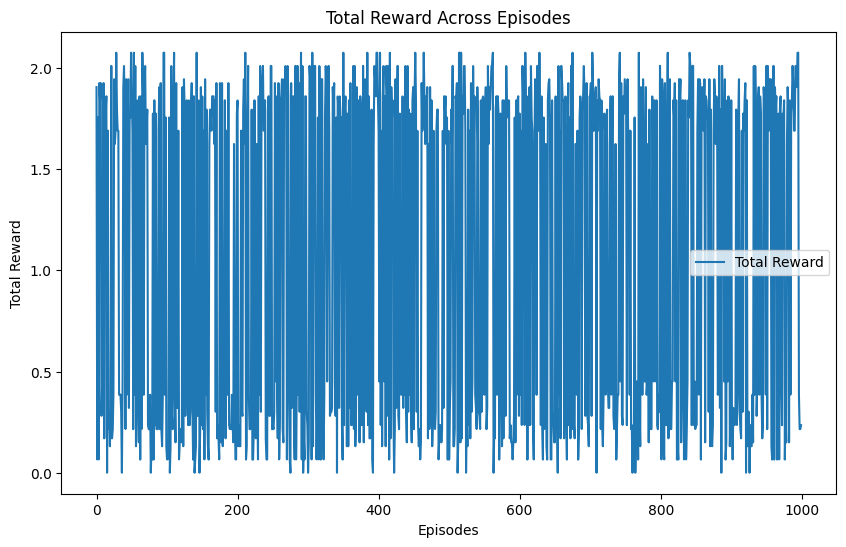

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import pandas as pd
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the Policy (Actor) and Value (Critic) Networks
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCriticNetwork, self).__init__()
        # Shared network layers
        self.shared_fc = nn.Linear(state_dim, hidden_dim)
        
        # Actor (Policy) Network
        self.actor_fc = nn.Linear(hidden_dim, action_dim)
        
        # Critic (Value) Network
        self.critic_fc = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.relu(self.shared_fc(state))
        
        # Actor outputs probabilities for actions
        action_probs = torch.softmax(self.actor_fc(x), dim=-1)
        
        # Critic outputs value of the state
        state_value = self.critic_fc(x)
        
        return action_probs, state_value

# Step 3: Define the PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, clip_eps=0.2, batch_size=32, update_epochs=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.batch_size = batch_size
        self.update_epochs = update_epochs

        # Initialize the actor-critic network and the optimizer
        self.network = ActorCriticNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)

        # Track the best combination and revenue
        self.best_combination = None
        self.best_revenue = -float('inf')
        self.reward_history = []  # List to store reward history

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probs, _ = self.network(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def compute_advantage(self, rewards, values, next_values, dones):
        # Ensure everything is in tensor format for calculations
        rewards = torch.tensor(rewards, dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)
        next_values = torch.tensor(next_values, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        # Calculate advantages using TD-error or GAE
        advantages = rewards + (1 - dones) * self.gamma * next_values - values
        return advantages

    def update(self, states, actions, old_log_probs, rewards, next_states, dones):
        # Convert data to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32)
        
        # Compute new log probabilities and state values
        action_probs, state_values = self.network(states)
        dist = Categorical(action_probs)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Compute advantage
        next_state_values = self.network(torch.tensor(next_states, dtype=torch.float32))[1]
        advantages = self.compute_advantage(rewards, state_values.detach(), next_state_values.detach(), dones)
        
        # Calculate ratio (for PPO objective)
        ratio = torch.exp(log_probs - old_log_probs)
        
        # PPO clipped objective
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages
        
        # Actor loss
        actor_loss = -torch.min(surrogate1, surrogate2).mean()
        
        # Critic loss (Value function loss)
        rewards = torch.tensor(rewards, dtype=torch.float32)  # Convert rewards to tensor
        critic_loss = (state_values - rewards).pow(2).mean()

        # Total loss = Actor loss + Critic loss - Entropy regularization
        loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy
        
        # Update the network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, n_episodes):
        for episode in range(n_episodes):
            state = np.random.choice([0, 1], size=n_skus)  # Random initial state (binary vector for SKU selection)
            done = False
            total_reward = 0
            states, actions, old_log_probs, rewards, next_states, dones = [], [], [], [], [], []

            while not done:
                action, log_prob = self.select_action(state)
                reward = self.calculate_revenue(state)  # Reward is the normalized revenue
                next_state = np.random.choice([0, 1], size=n_skus)  # Next state after taking action (random for simplicity)
                done = True  # End the episode after one step for simplicity
                total_reward += reward

                # Store the transition
                states.append(state)
                actions.append(action)
                old_log_probs.append(log_prob)
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(done)

                state = next_state

            # After episode ends, update the network using the collected data
            self.update(states, actions, old_log_probs, rewards, next_states, dones)

            # Print the SKU combination for this episode
            print(f"Episode {episode+1}/{n_episodes}, Product Combination: {state}, Total Reward: {total_reward}")

            # Track and print the best combination
            if total_reward > self.best_revenue:
                self.best_revenue = total_reward
                self.best_combination = state
                print(f"New Best Combination: {self.best_combination}, Revenue: {self.best_revenue}")

            # Store the total reward for plotting
            self.reward_history.append(total_reward)

        # Final best product combination after training ends
        print(f"\nFinal Best Product Combination: {self.best_combination}, Final Revenue: {self.best_revenue}")
        
        # Plotting the reward history across episodes
        self.plot_rewards()

    def calculate_revenue(self, state):
        # Calculate the revenue (normalized) based on the selected SKUs
        revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
        return revenue

    def plot_rewards(self):
        # Plot reward across all episodes
        plt.figure(figsize=(10, 6))
        plt.plot(self.reward_history, label="Total Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Total Reward Across Episodes")
        plt.legend()
        plt.show()

# Step 4: Train the PPO agent
ppo_agent = PPOAgent(state_dim=n_skus, action_dim=n_skus)

# Train for 1000 episodes
ppo_agent.train(n_episodes=1000)


## Genetic algorithm

In [9]:
import numpy as np
import pandas as pd
import random

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the genetic algorithm parameters
population_size = 20
n_generations = 100
mutation_rate = 0.1
elite_size = 4  # Number of top individuals to retain
tournament_size = 5

# Step 3: Define the fitness function (Revenue calculation)
def calculate_revenue(state):
    # Calculate the revenue (normalized) based on the selected SKUs
    revenue = np.sum(state * sku_data['utility'].values * sku_data['price'].values * sku_data['share'].values)
    return revenue

# Step 4: Create the initial population (random binary chromosomes)
def create_individual():
    return np.random.choice([0, 1], size=n_skus)  # Each SKU is either selected (1) or not (0)

def create_population():
    return [create_individual() for _ in range(population_size)]

# Step 5: Selection - Tournament selection
def tournament_selection(population):
    tournament = random.sample(population, tournament_size)
    tournament_fitness = [calculate_revenue(ind) for ind in tournament]
    best_individual = tournament[np.argmax(tournament_fitness)]
    return best_individual

# Step 6: Crossover - One-point crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, n_skus - 1)
    offspring = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    return offspring

# Step 7: Mutation - Random bit flip
def mutate(individual):
    for i in range(n_skus):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]  # Flip the bit
    return individual

# Step 8: Genetic Algorithm - Evolve population over generations
def genetic_algorithm():
    population = create_population()
    
    for generation in range(n_generations):
        # Evaluate the fitness of the population
        fitness_values = [calculate_revenue(ind) for ind in population]
        
        # Select the elite individuals (top performers)
        elite_individuals = sorted(zip(population, fitness_values), key=lambda x: x[1], reverse=True)[:elite_size]
        elite_population = [ind[0] for ind in elite_individuals]
        
        # Create new generation by selecting parents and applying crossover and mutation
        new_population = elite_population[:]  # Keep elite individuals
        
        while len(new_population) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            
            # Crossover
            offspring = crossover(parent1, parent2)
            
            # Mutation
            offspring = mutate(offspring)
            
            new_population.append(offspring)
        
        # Replace old population with new one
        population = new_population
        
        # Print the best fitness in this generation
        best_fitness = max(fitness_values)
        print(f"Generation {generation + 1}/{n_generations}, Best Revenue: {best_fitness:.2f}")
        
    # Return the best solution found
    best_individual = population[np.argmax(fitness_values)]
    return best_individual

# Step 9: Run the genetic algorithm
best_solution = genetic_algorithm()

# Display the best solution and its corresponding revenue
print("Best SKU Selection (Binary):", best_solution)
print("Corresponding Revenue:", calculate_revenue(best_solution))


Generation 1/100, Best Revenue: 2.07
Generation 2/100, Best Revenue: 2.07
Generation 3/100, Best Revenue: 2.07
Generation 4/100, Best Revenue: 2.07
Generation 5/100, Best Revenue: 2.07
Generation 6/100, Best Revenue: 2.07
Generation 7/100, Best Revenue: 2.07
Generation 8/100, Best Revenue: 2.07
Generation 9/100, Best Revenue: 2.07
Generation 10/100, Best Revenue: 2.07
Generation 11/100, Best Revenue: 2.07
Generation 12/100, Best Revenue: 2.07
Generation 13/100, Best Revenue: 2.07
Generation 14/100, Best Revenue: 2.07
Generation 15/100, Best Revenue: 2.07
Generation 16/100, Best Revenue: 2.07
Generation 17/100, Best Revenue: 2.07
Generation 18/100, Best Revenue: 2.07
Generation 19/100, Best Revenue: 2.07
Generation 20/100, Best Revenue: 2.07
Generation 21/100, Best Revenue: 2.07
Generation 22/100, Best Revenue: 2.07
Generation 23/100, Best Revenue: 2.07
Generation 24/100, Best Revenue: 2.07
Generation 25/100, Best Revenue: 2.07
Generation 26/100, Best Revenue: 2.07
Generation 27/100, Be

## FInal PPO

Episode 1, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 2, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 3, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 4, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 5, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 6, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 7, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 8, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 9, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 10, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 11, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 12, Total Reward: 553.4237711946225, Product Combination: [0. 0. 1. 1. 1.]
Episode 13, T

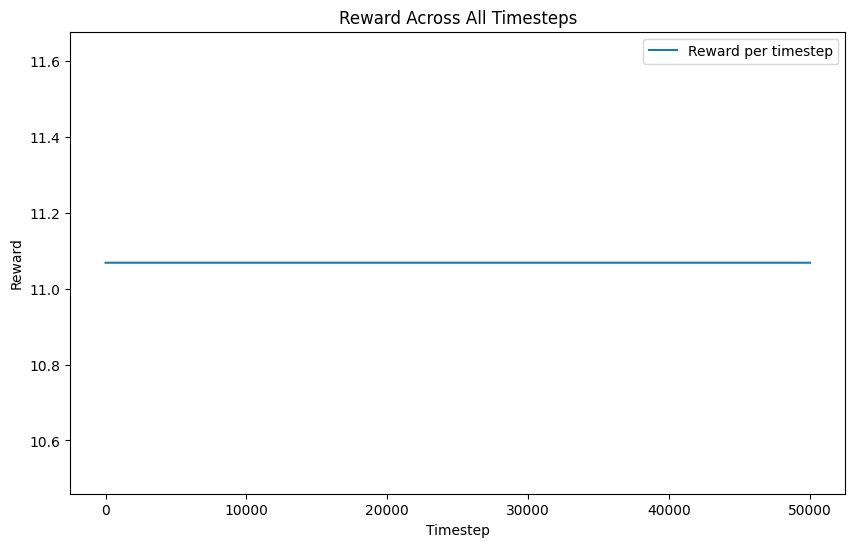

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Step 1: Create a dummy dataset for SKUs
np.random.seed(42)

n_skus = 5  # Number of SKUs
sku_data = pd.DataFrame({
    'utility': np.random.rand(n_skus),  # Random utilities between 0 and 1
    'price': np.random.rand(n_skus) * 10,  # Random prices between 0 and 10
    'volume': np.random.randint(1, 100, size=n_skus),  # Random volume between 1 and 100
})

# Normalize volume for simplicity (we can use this as a proxy for share within the nest)
sku_data['share'] = sku_data['volume'] / sku_data['volume'].sum()

# Step 2: Define the PPO Agent and Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)  # Output a probability distribution over actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        action_probs = torch.sigmoid(self.fc3(x))  # Output probabilities for each product selection (binary)
        return action_probs

class PPOAgent:
    def __init__(self, input_dim, output_dim, gamma=0.99, clip_epsilon=0.2, lr=.05):
        self.policy_network = PolicyNetwork(input_dim, output_dim)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.memory = []
        self.old_log_probs = []
        self.best_reward = -float('inf')
        self.best_combination = None
        self.reward_history = []  # Store reward history for all timesteps

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
        action_probs = self.policy_network(state)
        action_probs = action_probs.squeeze(0)  # Remove the batch dimension

        # Sample a binary vector for product selection
        action = (action_probs > 0.5).float()  # Choose 1 if probability > 0.5, otherwise 0

        log_prob = torch.sum(torch.log(action_probs) * action + torch.log(1 - action_probs) * (1 - action))
        self.old_log_probs.append(log_prob)
        return action, log_prob

    def store_experience(self, state, action, reward, log_prob):
        self.memory.append([state, action, reward, log_prob])

    def update_policy(self):
        states, actions, rewards, log_probs = zip(*self.memory)
        
        # Convert to tensors
        states = torch.stack([torch.FloatTensor(s) for s in states])
        actions = torch.stack(actions)  # Action is a binary vector, stack it
        rewards = torch.FloatTensor(rewards)
        old_log_probs = torch.stack([log_prob for log_prob in log_probs])

        # Calculate advantages (for simplicity, using Monte Carlo return)
        advantages = rewards - rewards.mean()

        # Compute the log probabilities for the actions
        new_log_probs = torch.sum(torch.log(self.policy_network(states)) * actions + torch.log(1 - self.policy_network(states)) * (1 - actions), dim=-1)

        # Compute the ratio of new and old probabilities
        ratio = torch.exp(new_log_probs - old_log_probs)

        # Compute the surrogate objective and loss
        surrogate_loss = ratio * advantages
        clipped_loss = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
        loss = -torch.min(surrogate_loss, clipped_loss).mean()

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clear memory for next training cycle
        self.memory.clear()

# Define the environment with the MNL model
class MNLRevenueEnv:
    def __init__(self, n_products, utilities, prices, outside_option):
        self.n_products = n_products
        self.utilities = utilities
        self.prices = prices
        self.outside_option = outside_option

    def get_state(self):
        # Return utilities and prices as state (flattened to match input_dim)
        return np.concatenate([self.utilities, self.prices])

    def get_reward(self, action):
        # action is a binary vector (0 or 1 for each product)
        selected_products = action
        predicted_share = []
        z = np.sum(np.exp(self.utilities))  # Sum of exponentiated utilities
        for i in range(self.n_products):
            predicted_share.append(np.exp(self.utilities[i]) / (z + self.outside_option) if selected_products[i] == 1 else 0)

        revenue = np.dot(predicted_share, self.prices)  # Revenue = predicted_share * price
        return revenue  # This is the reward to be maximized

    def reset(self):
        # Reset the environment
        return self.get_state()

# Step 3: Example usage: Define your MNL model and PPO agent
n_products = 5
utilities = np.random.uniform(0, 1, n_products)  # Random utilities for products
prices = np.random.uniform(5, 50, n_products)  # Random prices for products
outside_option = np.exp(np.min(utilities) * 0.00001)  # Outside option probability

env = MNLRevenueEnv(n_products, utilities, prices, outside_option)
ppo_agent = PPOAgent(input_dim=n_products * 2, output_dim=n_products)  # Example: utilities + prices as input

# Step 4: Simulate a few episodes
for episode in range(1000):
    state = env.reset()
    total_reward = 0
    done = False
    for step in range(50):  # Run for a certain number of steps (max 50 in this case)
        action, log_prob = ppo_agent.get_action(state)  # Select product combination
        reward = env.get_reward(action)
        ppo_agent.store_experience(state, action, reward, log_prob)  # Store experience

        total_reward += reward
        ppo_agent.reward_history.append(reward)  # Store reward for plotting

        if step % 10 == 0:  # Update policy every 10 steps (for example)
            ppo_agent.update_policy()

        # End episode (can use some condition)
        if step >= 50:
            done = True
            break

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Product Combination: {action.numpy()}")

    # Track the best product combination based on the highest reward
    if total_reward > ppo_agent.best_reward:
        ppo_agent.best_reward = total_reward
        ppo_agent.best_combination = action.numpy()

# Step 5: Print the best product combination after training ends
print(f"\nBest Reward: {ppo_agent.best_reward}")
print(f"Best Product Combination: {ppo_agent.best_combination}")

# Step 6: Plot the rewards across all timesteps
plt.figure(figsize=(10, 6))
plt.plot(ppo_agent.reward_history, label="Reward per timestep")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Reward Across All Timesteps")
plt.legend()
plt.show()
